# Modelagem de CNN - Pneumonia em Raio-X

Este notebook implementa e treina modelos de Redes Neurais Convolucionais (CNNs) para classificação de pneumonia em imagens de raio-X de tórax.

## Metodologia

- **Pré-processamento**: Redimensionamento, normalização, data augmentation
- **Divisão dos Dados**: 60% treino / 20% validação / 20% teste
- **Modelos**: CNN construída do zero
- **Avaliação**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Interpretabilidade**: Grad-CAM para visualizar regiões importantes


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import tensorflow as tf
from tensorflow import keras

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Importar módulos do projeto
from src.vision.data_loader import load_image_dataset
from src.vision.preprocessing import split_image_data, create_data_generators
from src.vision.models import (
    create_simple_cnn_pneumonia,
    compile_model,
    get_model_callbacks
)
from src.vision.evaluation import (
    plot_training_history,
    plot_confusion_matrix,
    plot_roc_curve,
    visualize_predictions,
    plot_grad_cam,
    evaluate_model
)

# Configuração
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Configurações do TensorFlow
tf.random.set_seed(config["split"]["random_state"])
np.random.seed(config["split"]["random_state"])

print("Módulos importados com sucesso!")
print(f"TensorFlow version: {tf.__version__}")


Módulos importados com sucesso!
TensorFlow version: 2.20.0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Recarregar módulos para garantir que estamos usando a versão mais recente
# Execute esta célula se encontrar erros relacionados a funções atualizadas
import importlib
import sys

# Recarregar módulos de avaliação e data_loader
if 'src.vision.evaluation' in sys.modules:
    importlib.reload(sys.modules['src.vision.evaluation'])
if 'src.vision.data_loader' in sys.modules:
    importlib.reload(sys.modules['src.vision.data_loader'])

# Re-importar as funções atualizadas
from src.vision.evaluation import plot_grad_cam, grad_cam_visualization
from src.vision.data_loader import find_pneumonia_dataset_path

print("Módulos recarregados com sucesso!")

Módulos recarregados com sucesso!


## 1. Preparação dos Dados

Carregamos o dataset e dividimos em conjuntos de treino, validação e teste.


In [3]:
# Carregar dataset
# Assumindo que o dataset já foi baixado no notebook de exploração
# Se não, descomente a linha abaixo:
# from src.vision.data_loader import download_pneumonia_dataset
# dataset_path = download_pneumonia_dataset(config["data"]["images"]["pneumonia_path"])

# Para este exemplo, vamos assumir que temos o path do dataset
# Em produção, você pode salvar o path do notebook de exploração
dataset_path = config["data"]["images"]["pneumonia_path"]

# Carregar imagens
df = load_image_dataset(dataset_path)

print(f"Total de imagens: {len(df)}")
print(f"Classes: {df['label'].unique()}")

# Se o dataset já tem split (train/test), vamos usar
# Caso contrário, vamos criar nosso próprio split
if 'split' in df.columns and 'train' in df['split'].values:
    # Usar split existente
    train_df = df[df['split'] == 'train'].copy()
    test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None
    
    # Se não houver validação, criar a partir do treino
    if 'val' in df['split'].values or 'validation' in df['split'].values:
        val_df = df[df['split'].isin(['val', 'validation'])].copy()
    else:
        train_df, val_df, _ = split_image_data(
            train_df,
            test_size=0.2,
            validation_size=0.2,
            random_state=config["split"]["random_state"]
        )
    
    if test_df is None:
        # Criar teste a partir do treino se não existir
        train_df, _, test_df = split_image_data(
            train_df,
            test_size=0.2,
            validation_size=0.0,
            random_state=config["split"]["random_state"]
        )
else:
    # Criar split do zero
    train_df, val_df, test_df = split_image_data(
        df,
        test_size=config["split"]["test_size"],
        validation_size=config["split"]["validation_size"],
        random_state=config["split"]["random_state"]
    )

print(f"\nDivisão dos dados:")
print(f"  Treino:    {len(train_df)} amostras ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validação: {len(val_df)} amostras ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Teste:     {len(test_df)} amostras ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nDistribuição das classes no treino:")
print(train_df['label'].value_counts())
print(f"\nDistribuição das classes na validação:")
print(val_df['label'].value_counts())
print(f"\nDistribuição das classes no teste:")
print(test_df['label'].value_counts())


Dataset encontrado no cache: /Users/vinicius/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Total de imagens: 5856
Classes: ['PNEUMONIA' 'NORMAL']

Divisão dos dados:
  Treino:    5216 amostras (89.1%)
  Validação: 16 amostras (0.3%)
  Teste:     624 amostras (10.7%)

Distribuição das classes no treino:
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

Distribuição das classes na validação:
label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64

Distribuição das classes no teste:
label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64


### 1.1 Criar Data Generators

Criamos generators para treino, validação e teste com data augmentation para o conjunto de treino.


In [4]:
# Configurações
image_size = tuple(config["models"]["cnn"]["image_size"]["pneumonia"])
batch_size = config["models"]["cnn"]["batch_size"]

# Criar data generators
train_gen, val_gen, test_gen = create_data_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    augmentation=True
)

# Obter nomes das classes
class_names = list(train_gen.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Índices das classes: {train_gen.class_indices}")

print(f"\nTamanho dos generators:")
print(f"  Treino:    {len(train_gen)} batches")
print(f"  Validação: {len(val_gen)} batches")
print(f"  Teste:     {len(test_gen)} batches")


Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Índices das classes: {'NORMAL': 0, 'PNEUMONIA': 1}

Tamanho dos generators:
  Treino:    163 batches
  Validação: 1 batches
  Teste:     20 batches


## 2. Modelo: CNN Simples

Vamos criar e treinar uma CNN construída do zero.


In [5]:
# Criar modelo
input_shape = (*image_size, 3)  # RGB
num_classes = len(class_names)

model = create_simple_cnn_pneumonia(
    input_shape=input_shape,
    num_classes=num_classes,
    dropout_rate=0.5
)

# Compilar modelo
learning_rate = config["models"]["cnn"]["learning_rate"]
model = compile_model(model, learning_rate=learning_rate)

# Resumo do modelo
print("Arquitetura do Modelo:")
print("=" * 60)
model.summary()


Arquitetura do Modelo:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 9,814,850 (37.44 MB)

 Trainable params: 9,812,610 (37.43 MB)

 Non-trainable params: 2,240 (8.75 KB)

### 2.1 Treinamento do Modelo


In [6]:
# Configurações de treinamento
epochs = config["models"]["cnn"]["epochs"]
patience = config["models"]["cnn"]["early_stopping_patience"]

# Criar callbacks
checkpoint_path = "../models/pneumonia_cnn_model.h5"
callbacks = get_model_callbacks(
    checkpoint_path=checkpoint_path,
    patience=patience,
    monitor='val_loss'
)

# Treinar modelo
print("Iniciando treinamento...")
print("=" * 60)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

print("\nTreinamento concluído!")


Iniciando treinamento...
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7611 - loss: 0.6734 - precision: 0.7611 - recall: 0.7611
Epoch 1: val_loss improved from None to 8.41156, saving model to ../models/pneumonia_cnn_model.h5



Epoch 1: finished saving model to ../models/pneumonia_cnn_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 353ms/step - accuracy: 0.8273 - loss: 0.4820 - precision: 0.8273 - recall: 0.8273 - val_accuracy: 0.5000 - val_loss: 8.4116 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8883 - loss: 0.3006 - precision: 0.8883 - recall: 0.8883
Epoch 2: val_loss improved from 8.41156 to 6.90135, saving model to ../models/pneumonia_cnn_model.h5



Epoch 2: finished saving model to ../models/pneumonia_cnn_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 376ms/step - accuracy: 0.8928 - loss: 0.2895 - precision: 0.8928 - recall: 0.8928 - val_accuracy: 0.5000 - val_loss: 6.9013 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9147 - loss: 0.2230 - precision: 0.9147 - recall: 0.9147
Epoch 3: val_loss improved from 6.90135 to 4.63617, saving model to ../models/pneumonia_cnn_model.h5



Epoch 3: finished saving model to ../models/pneumonia_cnn_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 445ms/step - accuracy: 0.9151 - loss: 0.2276 - precision: 0.9151 - recall: 0.9151 - val_accuracy: 0.5000 - val_loss: 4.6362 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9356 - loss: 0.1748 - precision: 0.9356 - recall: 0.9356
Epoch 4: val_loss did not improve from 4.63617
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 428ms/step - accuracy: 0.9369 - loss: 0.1734 - precision: 0.9369 - recall: 0.9369 - val_accuracy: 0.5000 - val_loss: 26.6629 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9363 - loss: 0.1779 - precision: 0.9363 - recall: 0.9363
Epoch 5: val_loss did not improve from 4.63617

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - accuracy: 0.


Epoch 6: finished saving model to ../models/pneumonia_cnn_model.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 457ms/step - accuracy: 0.9457 - loss: 0.1445 - precision: 0.9457 - recall: 0.9457 - val_accuracy: 0.5000 - val_loss: 1.4527 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9420 - loss: 0.1562 - precision: 0.9420 - recall: 0.9420
Epoch 7: val_loss did not improve from 1.45268
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 451ms/step - accuracy: 0.9442 - loss: 0.1514 - precision: 0.9442 - recall: 0.9442 - val_accuracy: 0.5000 - val_loss: 4.4823 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9540 - loss: 0.1379 - precision: 0.9540 - recall: 0.9540
Epoch 8: val_loss did not improve from 1.45268

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 452ms/step - accur

### 2.2 Visualização do Histórico de Treinamento


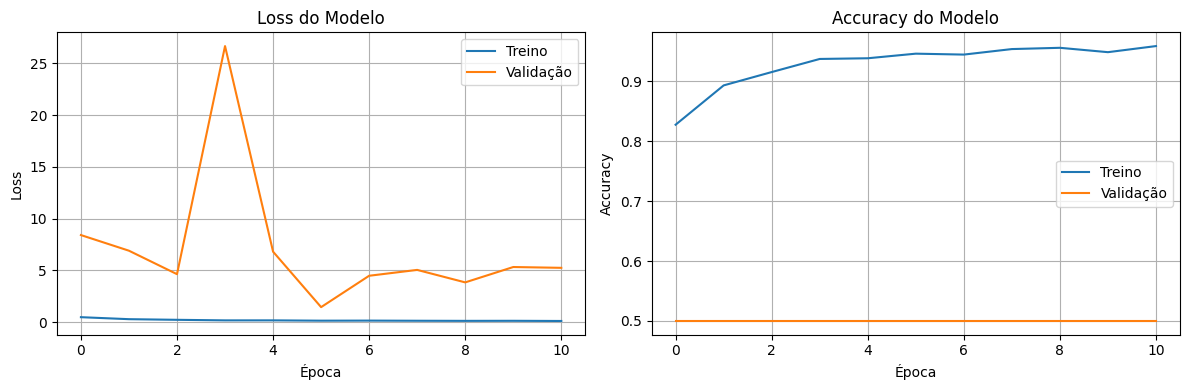

In [19]:
# Visualizar histórico de treinamento
plot_training_history(history)


## 3. Avaliação do Modelo

Avaliamos o modelo no conjunto de teste.


In [20]:
# Carregar melhor modelo (salvo pelo ModelCheckpoint)
best_model = keras.models.load_model(checkpoint_path)

# Avaliar modelo
print("Avaliação no Conjunto de Teste:")
print("=" * 60)
metrics = evaluate_model(best_model, test_gen, class_names, verbose=True)


Avaliação no Conjunto de Teste:


Métricas de Avaliação
Loss: 0.7629
Accuracy: 0.7644

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.38      0.54       234
   PNEUMONIA       0.73      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.86      0.69      0.69       624
weighted avg       0.83      0.76      0.73       624


ROC AUC por classe:
  NORMAL: 0.9398
  PNEUMONIA: 0.9398


### 3.1 Matriz de Confusão


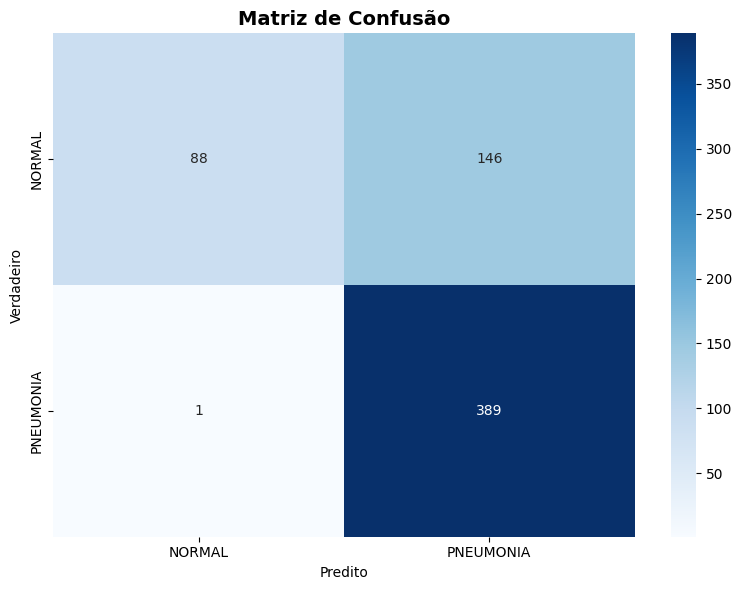

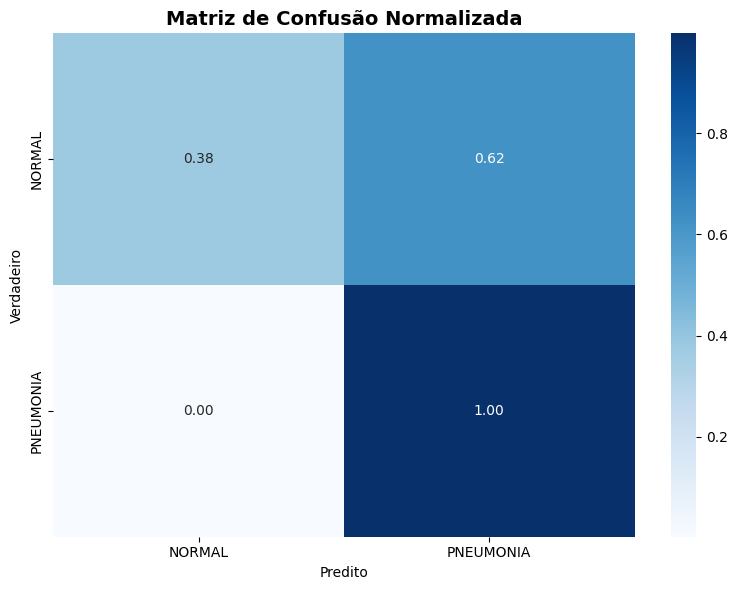

In [21]:
# Obter predições para matriz de confusão
y_pred_proba = best_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Obter labels verdadeiros
y_true = []
for i in range(len(test_gen)):
    _, y_batch = test_gen[i]
    y_true.extend(np.argmax(y_batch, axis=1))
y_true = np.array(y_true)

# Plotar matriz de confusão
plot_confusion_matrix(y_true, y_pred, class_names, normalize=False)
plot_confusion_matrix(y_true, y_pred, class_names, normalize=True)


### 3.2 Curva ROC


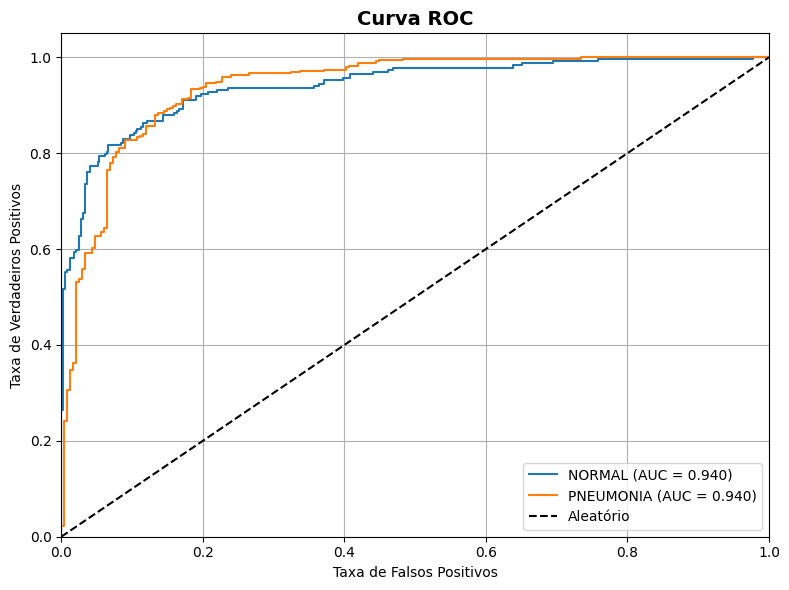

In [22]:
# Plotar curva ROC
y_true_onehot = keras.utils.to_categorical(y_true, len(class_names))
plot_roc_curve(y_true_onehot, y_pred_proba, class_names)


### 3.3 Visualização de Predições

Visualizamos algumas predições corretas e incorretas.


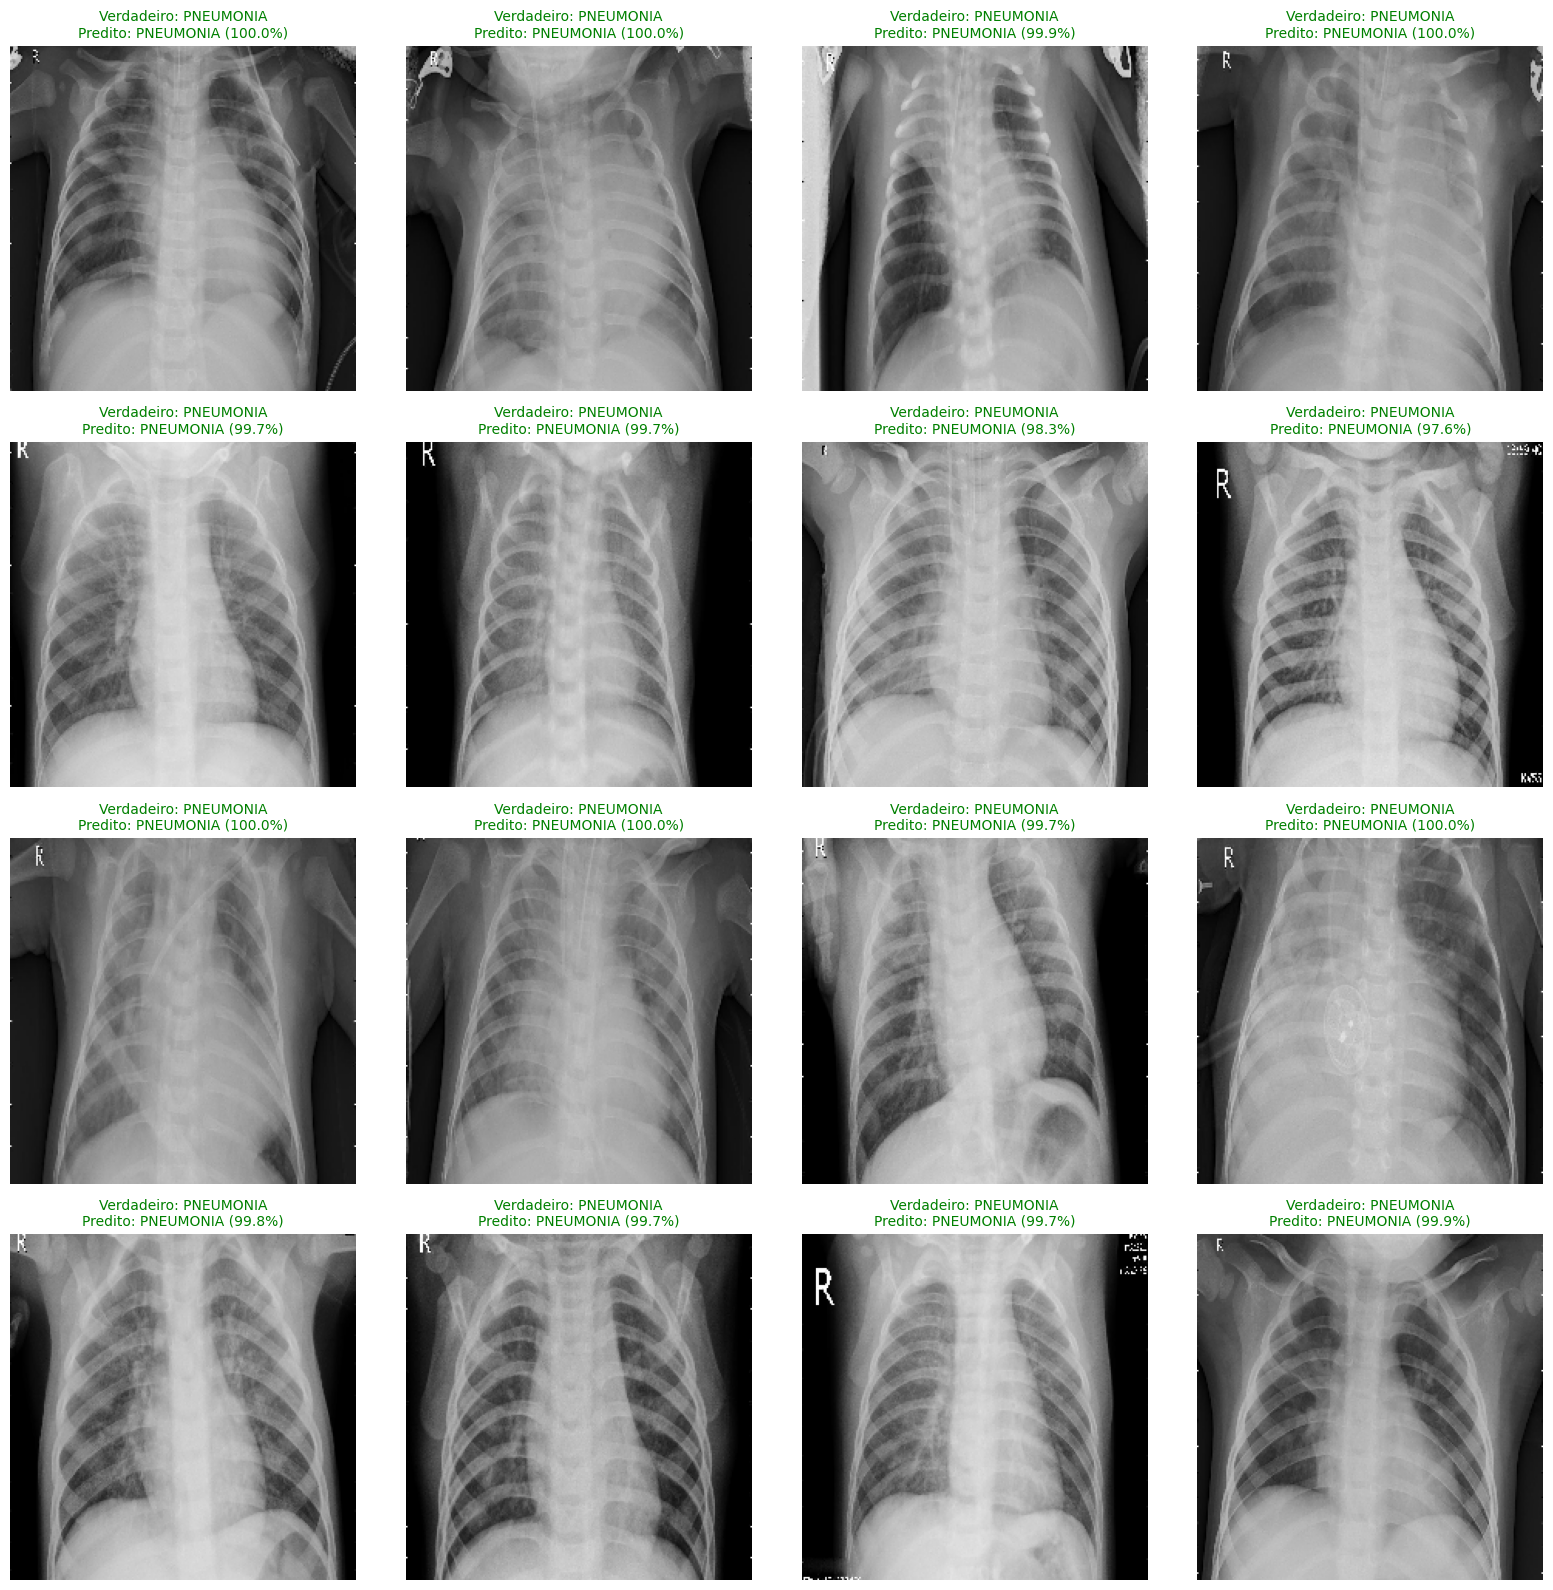

In [23]:
# Visualizar predições
visualize_predictions(best_model, test_gen, class_names, num_samples=16)


In [24]:
# FORÇAR RELOAD COMPLETO DO MÓDULO
import importlib
import sys

# Remover todas as referências
modules_to_remove = [k for k in list(sys.modules.keys()) if 'vision.evaluation' in k]
for mod in modules_to_remove:
    del sys.modules[mod]

# Recarregar
import src.vision.evaluation
importlib.reload(src.vision.evaluation)

# Re-importar as funções
from src.vision.evaluation import plot_grad_cam, grad_cam_visualization

print("Módulo recarregado com sucesso!")

Módulo recarregado com sucesso!


## 4. Interpretabilidade com Grad-CAM

Usamos Grad-CAM para visualizar as regiões da imagem que mais influenciam a predição do modelo.



Grad-CAM para amostra de classe 'PNEUMONIA':


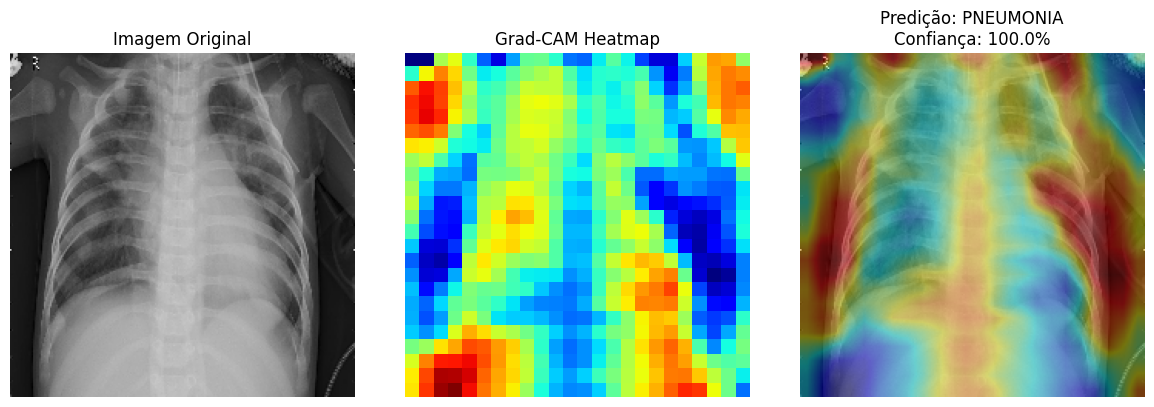

In [25]:
# Selecionar algumas amostras para análise Grad-CAM
num_gradcam_samples = 4

# Obter batch do test generator
x_batch, y_batch = test_gen[0]

# Selecionar amostras de cada classe
for class_idx, class_name in enumerate(class_names):
    class_samples = np.where(np.argmax(y_batch, axis=1) == class_idx)[0]
    if len(class_samples) > 0:
        sample_idx = class_samples[0]
        img_array = x_batch[sample_idx]
        
        print(f"\nGrad-CAM para amostra de classe '{class_name}':")
        plot_grad_cam(best_model, img_array, class_names)


## 5. Persistência do Modelo

O modelo já foi salvo automaticamente durante o treinamento pelo ModelCheckpoint. Vamos verificar e fazer uma validação final.


In [26]:
# Verificar se o modelo foi salvo
import os
if os.path.exists(checkpoint_path):
    print(f"Modelo salvo com sucesso em: {checkpoint_path}")
    
    # Carregar e validar modelo salvo
    loaded_model = keras.models.load_model(checkpoint_path)
    
    # Fazer uma predição de teste
    test_batch_x, test_batch_y = test_gen[0]
    test_pred = loaded_model.predict(test_batch_x[:1], verbose=0)
    test_true = np.argmax(test_batch_y[0])
    test_pred_class = np.argmax(test_pred[0])
    
    print(f"\nValidação do modelo carregado:")
    print(f"  Imagem de teste - Classe verdadeira: {class_names[test_true]}")
    print(f"  Predição: {class_names[test_pred_class]} (confiança: {test_pred[0][test_pred_class]*100:.2f}%)")
    print("\nModelo validado com sucesso!")
else:
    print(f"Modelo não encontrado em: {checkpoint_path}")
    print("Salvando modelo manualmente...")
    best_model.save(checkpoint_path)
    print("Modelo salvo!")


Modelo salvo com sucesso em: ../models/pneumonia_cnn_model.h5

Validação do modelo carregado:
  Imagem de teste - Classe verdadeira: PNEUMONIA
  Predição: PNEUMONIA (confiança: 99.97%)

Modelo validado com sucesso!
